# Figure 4: MNIST ReLU vs softmax per architecture

Compares ReLU and softmax kernels side-by-side for each architecture and `m` setting using MNIST summary CSVs.


In [7]:
from pathlib import Path
import pandas as pd

# Locate results/MNIST even if the notebook is launched from a subdirectory

def find_mnist_results_dir(start=None):
    start = Path.cwd() if start is None else Path(start)
    for path in [start, *start.parents]:
        candidate = path / "results" / "MNIST"
        if candidate.exists():
            return candidate
    raise FileNotFoundError("Could not find results/MNIST relative to the current working directory.")

mnist_results = find_mnist_results_dir()
summary_files = sorted(mnist_results.glob("summary_*.csv"))
if not summary_files:
    raise FileNotFoundError(f"No summary_*.csv files found under {mnist_results}")

rows = []
for csv_path in summary_files:
    df = pd.read_csv(csv_path)
    if "best_test_acc" not in df.columns:
        continue
    for _, row in df.iterrows():
        if str(row.get("dataset", "")).lower() != "mnist":
            continue
        kernel = str(row.get("kernel_type", ""))
        if kernel not in {"relu", "softmax"}:
            continue
        arch = str(row.get("architecture", "unknown"))
        m_feat = str(row.get("m_features", ""))
        rows.append(
            {
                "architecture": arch,
                "kernel_type": kernel,
                "m_features": m_feat,
                "best_test_acc": float(row["best_test_acc"]),
                "summary_file": csv_path.name,
            }
        )

acc_df = pd.DataFrame(rows)
if acc_df.empty:
    raise ValueError("No MNIST rows with relu/softmax found in summary files.")
acc_df.head()


,architecture,kernel_type,m_features,best_test_acc,summary_file
0,all_performer,relu,128,98.85,summary_arch-all_performer_kernel-relu_m-128.csv
1,all_performer,relu,16,98.65,summary_arch-all_performer_kernel-relu_m-16.csv
2,all_performer,relu,256,98.67,summary_arch-all_performer_kernel-relu_m-256.csv
3,all_performer,relu,32,98.75,summary_arch-all_performer_kernel-relu_m-32.csv
4,all_performer,relu,64,98.51,summary_arch-all_performer_kernel-relu_m-64.csv


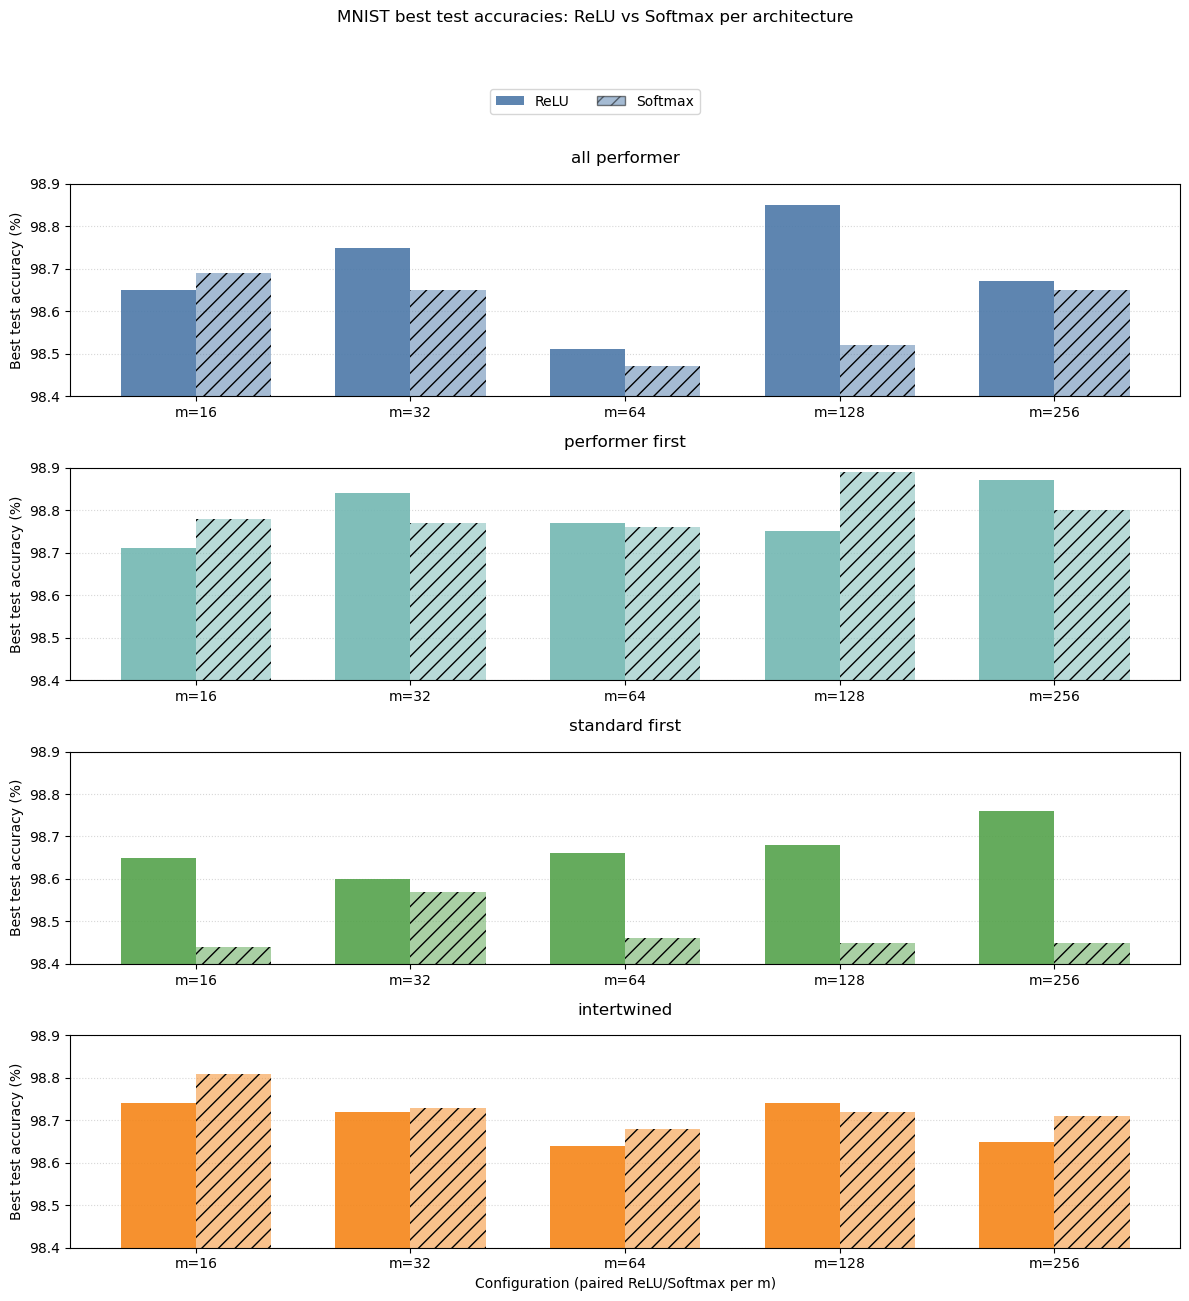

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

arch_colors = {
    "all_performer": "#4C78A8",
    "performer_first": "#72B7B2",
    "standard_first": "#54A24B",
    "intertwined": "#F58518",
}

architectures = [a for a in arch_colors if a in acc_df["architecture"].unique()]
if not architectures:
    raise ValueError("No architectures found in acc_df matching arch_colors keys.")

fig, axes = plt.subplots(len(architectures), 1, figsize=(12, max(3, 3 * len(architectures))), sharex=False)
if len(architectures) == 1:
    axes = [axes]

bar_width = 0.35
for ax, arch in zip(axes, architectures):
    df_arch = acc_df[acc_df["architecture"] == arch]
    if df_arch.empty:
        continue
    def m_sort_key(val: str):
        try:
            return float(val)
        except ValueError:
            return val
    m_values = sorted(df_arch["m_features"].unique(), key=m_sort_key)
    x = np.arange(len(m_values))

    relu_vals, softmax_vals = [], []
    for m in m_values:
        relu_row = df_arch[(df_arch["m_features"] == m) & (df_arch["kernel_type"] == "relu")]
        soft_row = df_arch[(df_arch["m_features"] == m) & (df_arch["kernel_type"] == "softmax")]
        relu_vals.append(float(relu_row["best_test_acc"].iloc[0]) if not relu_row.empty else np.nan)
        softmax_vals.append(float(soft_row["best_test_acc"].iloc[0]) if not soft_row.empty else np.nan)

    base_color = arch_colors[arch]
    ax.bar(x - bar_width / 2, relu_vals, width=bar_width, color=base_color, alpha=0.9, label="ReLU", zorder=2)
    ax.bar(x + bar_width / 2, softmax_vals, width=bar_width, color=base_color, alpha=0.5, hatch="//", label="Softmax", zorder=2)

    ax.set_ylim(98.4, 98.9)
    ax.set_title(arch.replace("_", " "), pad=15)
    ax.set_ylabel("Best test accuracy (%)")
    ax.set_xticks(x)
    ax.set_xticklabels([f"m={m}" for m in m_values])
    ax.grid(axis="y", linestyle=":", alpha=0.5, zorder=1)

axes[-1].set_xlabel("Configuration (paired ReLU/Softmax per m)")

style_handles = [
    Patch(facecolor="#4C78A8", label="ReLU", alpha=0.9),
    Patch(facecolor="#4C78A8", label="Softmax", alpha=0.5, hatch="//", edgecolor="black"),
]
fig.legend(handles=style_handles, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.02))

fig.suptitle("MNIST best test accuracies: ReLU vs Softmax per architecture", y=1.08)
plt.tight_layout()


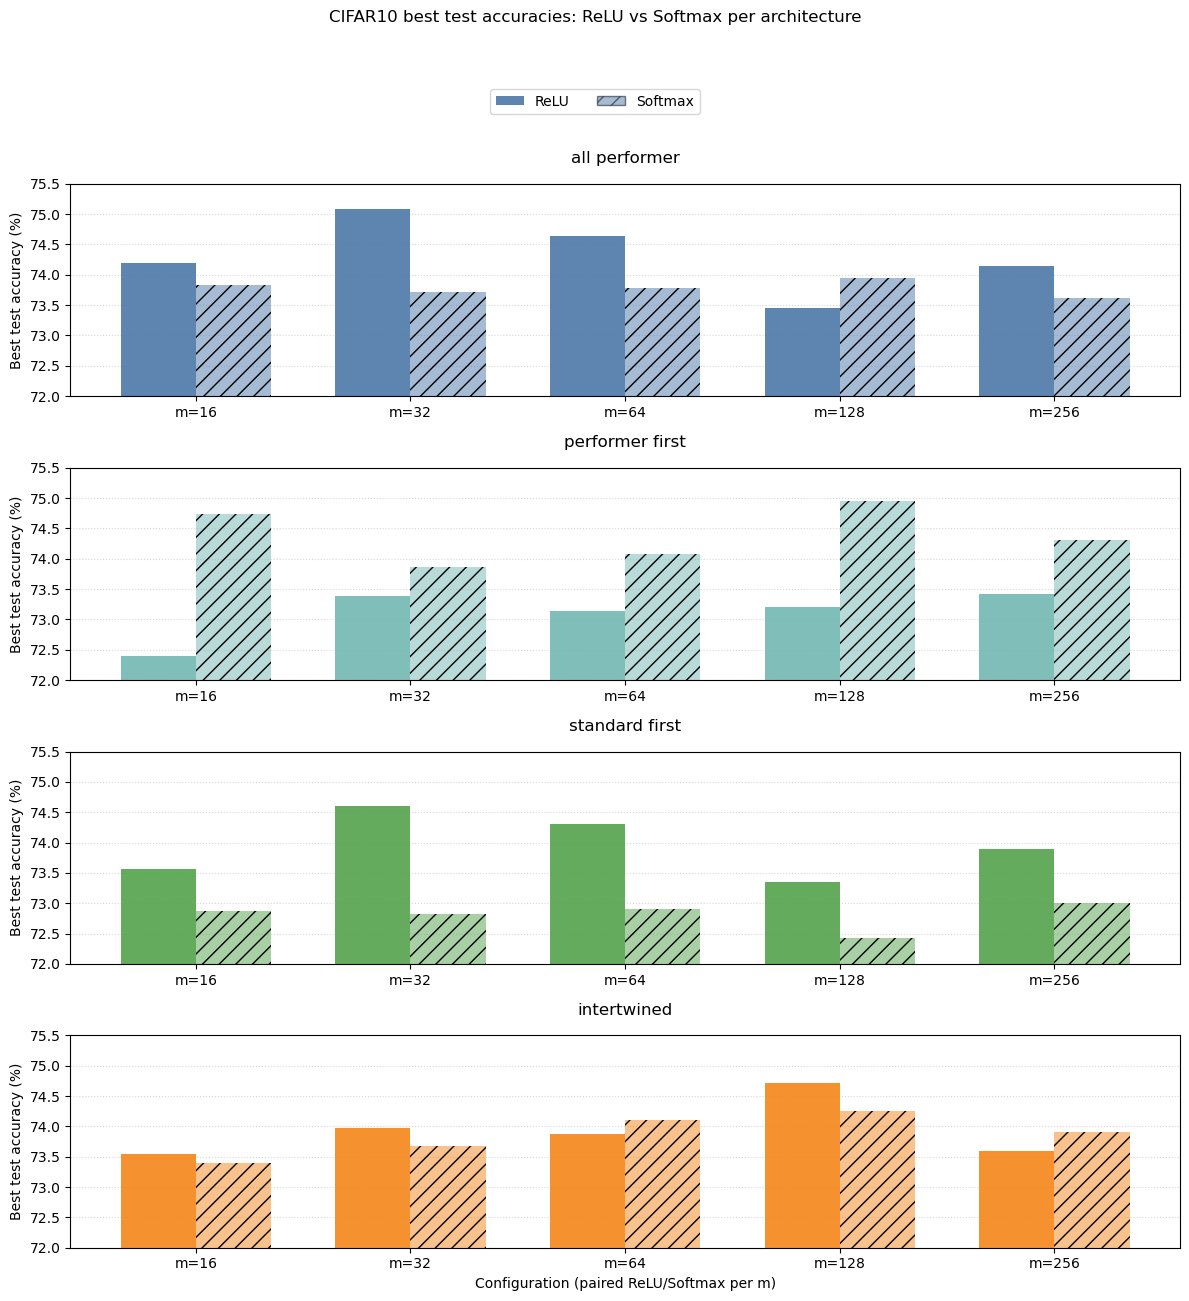

In [12]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load CIFAR10 summaries
def find_cifar_results_dir(start=None):
    start = Path.cwd() if start is None else Path(start)
    for path in [start, *start.parents]:
        candidate = path / "results" / "CIFAR10"
        if candidate.exists():
            return candidate
    raise FileNotFoundError("Could not find results/CIFAR10 relative to the current working directory.")

cifar_results = find_cifar_results_dir()
summary_files = sorted(cifar_results.glob("summary_*.csv"))
if not summary_files:
    raise FileNotFoundError(f"No summary_*.csv files found under {cifar_results}")

rows = []
for csv_path in summary_files:
    df = pd.read_csv(csv_path)
    if "best_test_acc" not in df.columns:
        continue
    for _, row in df.iterrows():
        if str(row.get("dataset", "")).lower() != "cifar10":
            continue
        kernel = str(row.get("kernel_type", ""))
        if kernel not in {"relu", "softmax"}:
            continue
        arch = str(row.get("architecture", "unknown"))
        if arch not in {"all_performer", "performer_first", "standard_first", "intertwined"}:
            continue
        m_feat = str(row.get("m_features", ""))
        if m_feat == "512":
            continue
        rows.append(
            {
                "architecture": arch,
                "kernel_type": kernel,
                "m_features": m_feat,
                "best_test_acc": float(row["best_test_acc"]),
                "summary_file": csv_path.name,
            }
        )

acc_df = pd.DataFrame(rows)
if acc_df.empty:
    raise ValueError("No CIFAR10 rows with relu/softmax found in summary files.")

arch_colors = {
    "all_performer": "#4C78A8",
    "performer_first": "#72B7B2",
    "standard_first": "#54A24B",
    "intertwined": "#F58518",
}

architectures = [a for a in arch_colors if a in acc_df["architecture"].unique()]
if not architectures:
    raise ValueError("No architectures found in acc_df matching arch_colors keys.")

fig, axes = plt.subplots(len(architectures), 1, figsize=(12, max(3, 3 * len(architectures))), sharex=False)
if len(architectures) == 1:
    axes = [axes]

bar_width = 0.35
for ax, arch in zip(axes, architectures):
    df_arch = acc_df[acc_df["architecture"] == arch]
    if df_arch.empty:
        continue
    def m_sort_key(val: str):
        try:
            return float(val)
        except ValueError:
            return val
    m_values = sorted(df_arch["m_features"].unique(), key=m_sort_key)
    x = np.arange(len(m_values))

    relu_vals, softmax_vals = [], []
    for m in m_values:
        relu_row = df_arch[(df_arch["m_features"] == m) & (df_arch["kernel_type"] == "relu")]
        soft_row = df_arch[(df_arch["m_features"] == m) & (df_arch["kernel_type"] == "softmax")]
        relu_vals.append(float(relu_row["best_test_acc"].iloc[0]) if not relu_row.empty else np.nan)
        softmax_vals.append(float(soft_row["best_test_acc"].iloc[0]) if not soft_row.empty else np.nan)

    base_color = arch_colors[arch]
    ax.bar(x - bar_width / 2, relu_vals, width=bar_width, color=base_color, alpha=0.9, label="ReLU", zorder=2)
    ax.bar(x + bar_width / 2, softmax_vals, width=bar_width, color=base_color, alpha=0.5, hatch="//", label="Softmax", zorder=2)

    ax.set_ylim(72, 75.5)
    ax.set_title(arch.replace("_", " "), pad=15)  # add space between title and ticks
    ax.set_ylabel("Best test accuracy (%)")
    ax.set_xticks(x)
    ax.set_xticklabels([f"m={m}" for m in m_values])
    ax.grid(axis="y", linestyle=":", alpha=0.5, zorder=1)

axes[-1].set_xlabel("Configuration (paired ReLU/Softmax per m)")

style_handles = [
    Patch(facecolor="#4C78A8", label="ReLU", alpha=0.9),
    Patch(facecolor="#4C78A8", label="Softmax", alpha=0.5, hatch="//", edgecolor="black"),
]
fig.legend(handles=style_handles, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.02))

fig.suptitle("CIFAR10 best test accuracies: ReLU vs Softmax per architecture", y=1.08)
plt.tight_layout()
